In [582]:
%load_ext autoreload
%autoreload 2

import src.kelly_bot as kelly
import src.game_env as game_env
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [583]:
# The lenght of a round
round_length = 40000
N_bots = 40

# This is the bias that we have about the coin probability 
p0_bias = 0.5
dp0_bias = 0.1

p0_real = 0.51

strategy1={}
strategy1['name'] = 'adaptive_kelly'
strategy1['kelly_fraction'] = 1.0


strategy2={}
strategy2['name'] = 'adaptive_kelly'
strategy2['kelly_fraction'] = 0.5

strategy3={}
strategy3['name'] = 'fixed_fraction'
strategy3['f_fixed'] = 0.1

kelly_bots_full = [kelly.Kelly_bot(strategy=strategy1,p0=p0_bias,dp0=dp0_bias,lam=lam) for lam in np.linspace(0.0,0.9,num=N_bots)]
kelly_bots_frac = [kelly.Kelly_bot(strategy=strategy2,p0=p0_bias,dp0=dp0_bias,lam=lam) for lam in np.linspace(0.0,0.9,num=N_bots)]
kelly_bots_fixed_frac = [kelly.Kelly_bot(strategy=strategy3,p0=p0_bias,dp0=dp0_bias,lam=lam) for lam in np.linspace(0.0,0.5,num=N_bots)]

game1 = game_env.Game_env(p0=p0_real,kelly_bots=kelly_bots_full)
game2 = game_env.Game_env(p0=p0_real,kelly_bots=kelly_bots_frac)
game3 = game_env.Game_env(p0=p0_real,kelly_bots=kelly_bots_fixed_frac)

kelly_bots_full = game1.simulate_game(N_rounds=round_length)
kelly_bots_frac = game2.simulate_game(N_rounds=round_length)
kelly_bots_fixed_frac = game3.simulate_game(N_rounds=round_length)

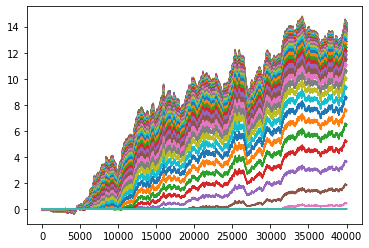

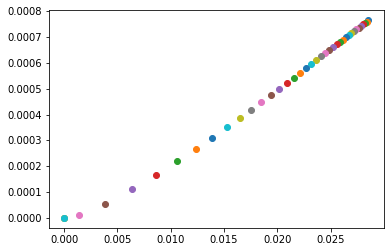

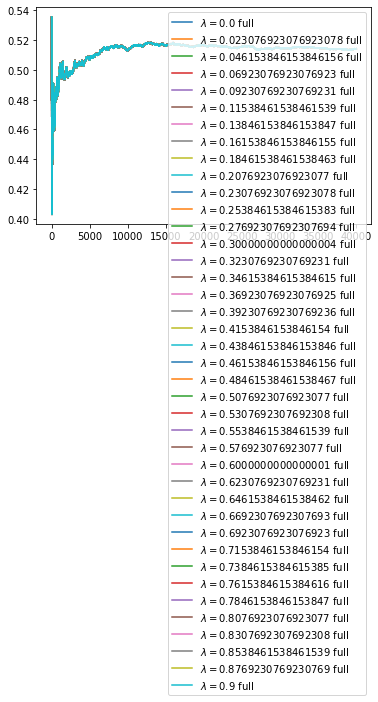

In [581]:
#plt.plot(kelly_bots_fixed_frac[0].dW_vec,label=' fixed frac')

for k in range(N_bots):
    plt.plot(np.log(kelly_bots_full[k].W_vec),label="$\lambda =$"+str(kelly_bots_full[k].lam)+' full')

#plt.legend()
plt.show()


ratio = []
plt.clf()
for k in range(N_bots):
    mean_k = np.mean(kelly_bots_full[k].dW_vec)
    std_k = np.std(kelly_bots_full[k].dW_vec)
    #print(mean_k/std_k,round(kelly_bots_full[k].lam,3))
    plt.scatter(std_k,mean_k,label="$\lambda =$"+str(kelly_bots_full[k].lam)+' full')

#plt.legend()
plt.show()


for k in range(N_bots):
    #plt.plot(kelly_bots_frac[k].W_vec,label=str(kelly_bots_frac[k].lam)+' frac')
    plt.plot(kelly_bots_full[k].p_vec,label="$\lambda =$"+str(kelly_bots_full[k].lam)+' full')

plt.legend()
plt.show()

In [480]:
N_games = 3000
round_length = 500
N_bots = 5

W1_final = np.zeros(N_games)
W2_final = np.zeros(N_games)
W3_final = np.zeros(N_games)
W_bots_final = np.zeros((N_games,N_bots))

for g in range(N_games):

    bot1 =  kelly.Kelly_bot(p0=0.0,dp0=0.0,strategy=strategy)
    bot2 =  kelly.Kelly_bot(p0=0.5,dp0=0.1,strategy=strategy)
    bot3 =  kelly.Kelly_bot(p0=0.5,dp0=0.1,strategy=strategy)
    
    bots = [kelly.Kelly_bot(strategy=strategy,p0=0.5,dp0=0.1) for lam in np.linspace(0.0,0.5,num=N_bots)]

    for k in range(0,round_length):

        f, betsize = bot1.fixed_bet_size(f_fixed=0.1)

        f2, betsize2 = bot2.fixed_bet_size(f_fixed=0.3)
        #f2, betsize2 = bot2.kelly_bet_size()
        
        f3, betsize3 = bot3.kelly_bet_size()
        
        # Flip the coin
        c=np.random.binomial(n=1,p=0.6)
        
        for i in range(len(bots)):
            fi,betsize_i = bots[i].kelly_bet_size()
            bots[i].new_observation(obs=c)
            bots[i].update_wealth(c,betsize_i)

        bot1.new_observation(obs=c)
        bot1.update_wealth(c,betsize)

        bot2.new_observation(obs=c)
        bot2.update_wealth(c,betsize2)
        
        bot3.new_observation(obs=c)
        bot3.update_wealth(c,betsize3)
    
    W1_final[g] = bot1.W_vec[-1]
    W2_final[g] = bot2.W_vec[-1]
    W3_final[g] = bot3.W_vec[-1]
    W_bots_final[g,:] = np.array([bots[i].W_vec[-1] for i in range(len(bots))])

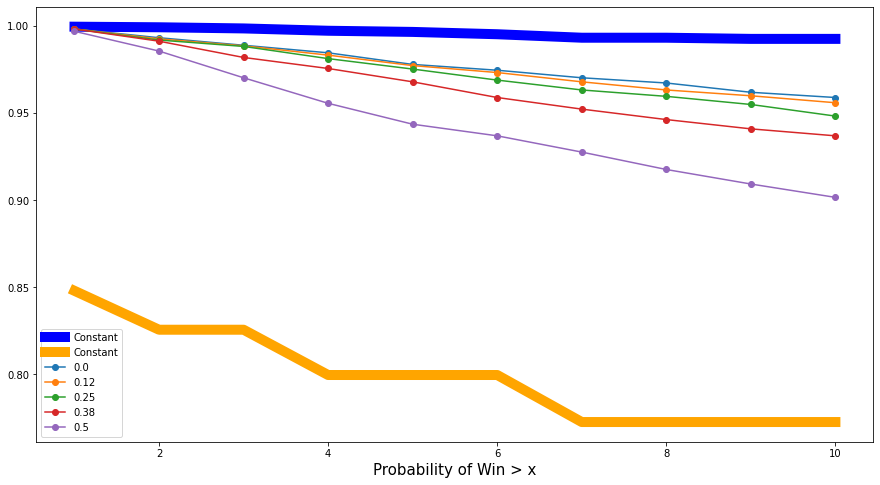

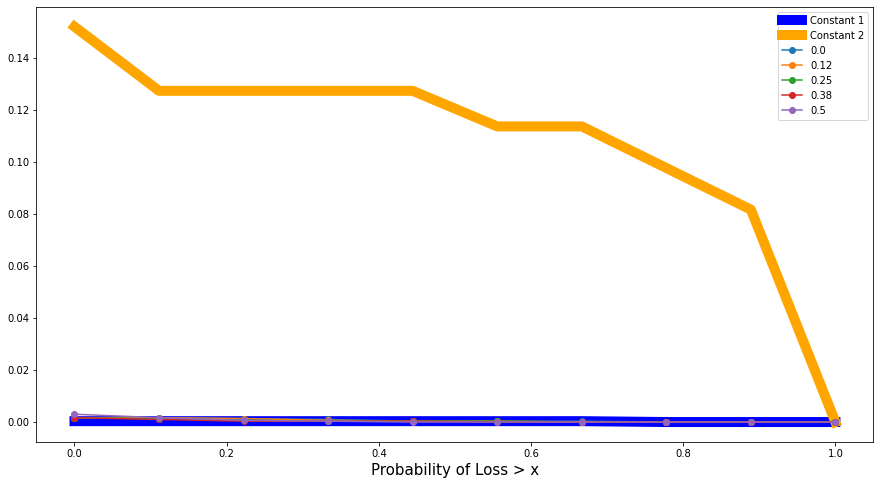

In [491]:
wins = np.linspace(1.0,10.0,num=10)
losses = np.linspace(0.0,1.0,num=10)

W_win_stats = np.zeros((len(bots),len(wins)))
W_loss_stats = np.zeros((len(bots),len(losses)))


W1_loss_stats = np.array([np.sum((W1_final<=lk))/N_games for lk in losses])
W1_win_stats = np.array([np.sum((W1_final>=wk))/N_games for wk in wins])

W2_loss_stats = np.array([np.sum((W2_final<=lk))/N_games for lk in losses])
W2_win_stats = np.array([np.sum((W2_final>=wk))/N_games for wk in wins])

for i in range(len(bots)):
    W_win_stats[i,:]= np.array([np.sum(W_bots_final[:,i]>=wk)/N_games for wk in wins])
    W_loss_stats[i,:]= np.array([np.sum(W_bots_final[:,i]<=lk)/N_games for lk in losses])

plt.figure(figsize=(15,8))

plt.plot(wins,W1_win_stats,'-o',label='Constant',linewidth=10,color='blue')
plt.plot(wins,W2_win_stats,'-o',label='Constant',linewidth=10,color='orange')

for i in range(len(bots)):
    plt.plot(wins,W_win_stats[i],'-o',label= round(bots[i].lam,2))

#plt.ylim(0.0,0.2)
plt.xlabel('Probability of Win > x',size=15)
plt.legend()
plt.show()



plt.figure(figsize=(15,8))

plt.plot(1-losses,W1_loss_stats,'-o',label='Constant 1',linewidth=10,color='blue')
plt.plot(1-losses,W2_loss_stats,'-o',label='Constant 2',linewidth=10,color='orange')

for i in range(len(bots)):
    plt.plot(1-losses,W_loss_stats[i],'-o',label= round(bots[i].lam,2))

#plt.ylim(0.0,0.003)
plt.xlabel('Probability of Loss > x',size=15)
plt.legend()
plt.show()

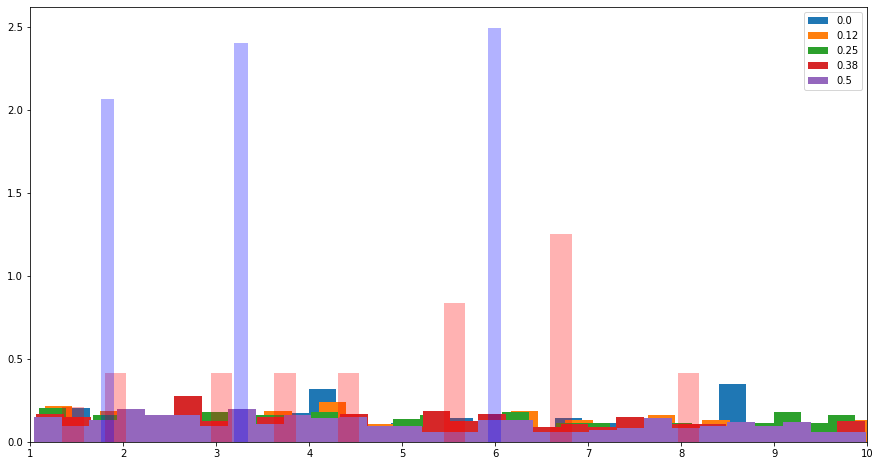

In [483]:
#for i in range(len(bots)):
#    W_win_stats[i,:]= np.array([np.sum( (W_bots_final[:,i]<=wk+0.5) & (W_bots_final[:,i]>=wk-0.5) )/N_games for wk in wins])
#    W_loss_stats[i,:]= np.array([np.sum(W_bots_final[:,i]<=lk)/N_games for lk in losses])

bins = 30
xmin = 1
xmax = 10

plt.figure(figsize=(15,8))


for i in range(len(bots)):
    W_temp = W_bots_final[:,i]
    W_temp = W_temp[(W_bots_final[:,i] > xmin) & (W_bots_final[:,i] < xmax) ]
    plt.hist(W_temp,density=True,bins=bins,label=round(bots[i].lam,2))

W1_final_cut = W1_final[(W1_final> xmin)&((W1_final< xmax))]
W2_final_cut = W2_final[(W2_final> xmin)&((W2_final< xmax))]
plt.hist(W1_final_cut,density=True,bins=bins,color='red',alpha=0.3)
plt.hist(W2_final_cut,density=True,bins=bins,color='blue',alpha=0.3)
plt.xlim(xmin,xmax)
plt.legend()
plt.show()

[0.603  0.603  0.603  0.603  0.603  0.604  0.6055 0.6065 0.607  0.608
 0.6085 0.61   0.6105 0.611  0.611  0.612  0.613  0.615  0.616  0.618
 0.6185 0.6185 0.6195 0.62   0.622  0.623  0.624  0.6245 0.625  0.626 ] 18.392000000000003


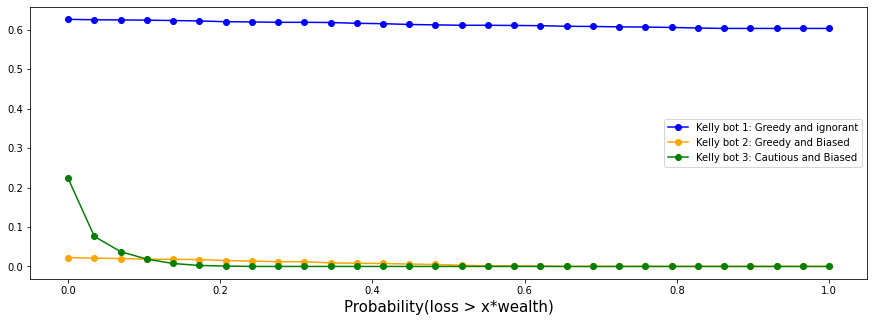

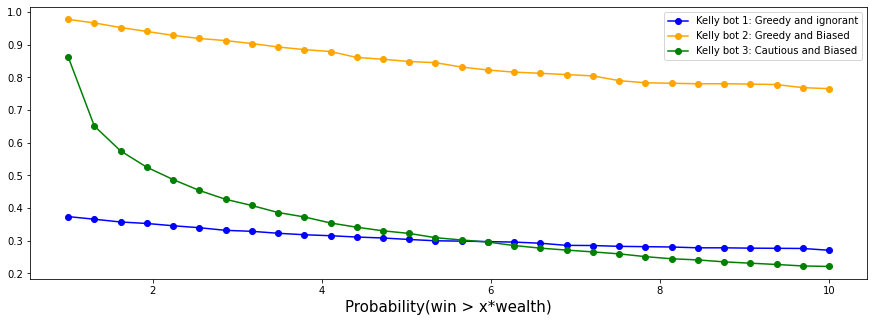

In [356]:
losses = np.linspace(0.0,1.0,num=30)
wins = np.linspace(1.0,10.0,num=30)

#W1_loss_stats = np.array([(np.sum((W1_final<=lk+dx[0])&(W1_final>=lk-dx[0]))/N_games) for lk in losses])
#W2_loss_stats = np.array([(np.sum((W2_final<=lk+dx[0])&(W2_final>=lk-dx[0]))/N_games) for lk in losses])
W1_loss_stats = np.array([np.sum(W1_final<=lk)/N_games for lk in losses])
W2_loss_stats = np.array([np.sum(W2_final<=lk)/N_games for lk in losses])
W3_loss_stats = np.array([np.sum(W3_final<=lk)/N_games for lk in losses])


W1_win_stats = np.array([(np.sum(W1_final>=wk)/N_games) for wk in wins])
W2_win_stats = np.array([(np.sum(W2_final>=wk)/N_games) for wk in wins])
W3_win_stats = np.array([(np.sum(W3_final>=wk)/N_games) for wk in wins])


def derivative(x,y):win
    
    dy = (y[1:]-y[:-1])/(x[1:]-x[:-1])
    
    return dy

print(W1_loss_stats,np.sum(W1_loss_stats))
plt.figure(figsize=(15,5))
plt.plot(1-losses,W1_loss_stats,'-o',color='blue',label='Kelly bot 1: Greedy and ignorant')
plt.plot(1-losses,W2_loss_stats,'-o',color='orange', label = 'Kelly bot 2: Greedy and Biased')
plt.plot(1-losses,W3_loss_stats,'-o',color='green', label = 'Kelly bot 3: Cautious and Biased')

plt.legend()
plt.xlabel('Probability(loss > x*wealth)',size=15)
plt.show()


plt.figure(figsize=(15,5))
plt.plot(wins,W1_win_stats,'-o',color='blue',label='Kelly bot 1: Greedy and ignorant')
plt.plot(wins,W2_win_stats,'-o',color='orange',label = 'Kelly bot 2: Greedy and Biased')
plt.plot(wins,W3_win_stats,'-o',color='green', label = 'Kelly bot 3: Cautious and Biased')
plt.xlabel('Probability(win > x*wealth)',size=15)
plt.legend()
plt.show()

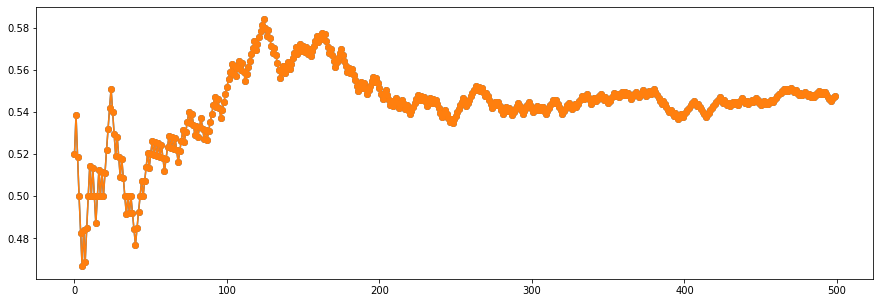

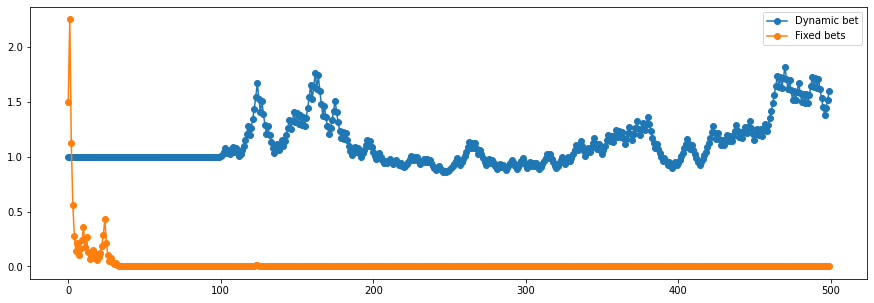

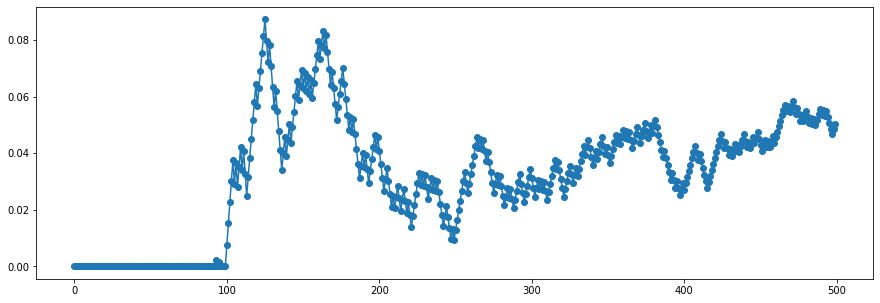

In [224]:
plt.figure(figsize=(15,5))
plt.plot(bot1.p_vec,'-o')
plt.plot(bot2.p_vec,'-o')
#plt.plot(bot1.p_vec+bot1.dp_vec,'-o')
#plt.plot(bot1.p_vec-bot1.dp_vec,'-o')
#plt.fill_between()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(bot1.W_vec,'-o',label='Dynamic bet')
plt.plot(bot2.W_vec,'-o',label='Fixed bets')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(bot1.f_vec,'-o')
plt.show()

In [360]:
a=[bot3.kelly_bet_size() for k in range(5)]

In [362]:
a[0][0]

0.08332917699725415